# Performance for Classification

In [3]:
import mglearn
import sklearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mlxtend.classifier import Adaline
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

from scipy.special import expit

from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.linear_model import Perceptron, LogisticRegression

In [4]:
def plot_digit(image_data):
    image = image_data.reshape((28, 28))
    plt.imshow(image, cmap='binary')
    plt.axis('off')

## Data loading

In [5]:
heart = pd.read_csv('data/heart.csv')
labels = heart['output'].values
heart.drop(['output'], axis=1, inplace=True)

In [6]:
heart_ct = ColumnTransformer(
    transformers=[
        ('1', MinMaxScaler(), ['age', 'caa', 'slp', 'thall']),
        ('2', OneHotEncoder(drop='first', categories='auto'), ['cp', 'restecg']), # we remove the first column generated by OHE, we don't need it
        ('3', StandardScaler(), ['trtbps', 'oldpeak', 'chol', 'fbs', 'thalachh'])
    ],
    verbose_feature_names_out=False, # reduce the name of the features given by OHE when it creates new columns
    remainder='passthrough' # the column not specified above are not the subject of transformation
)

X = heart_ct.fit_transform(heart) # this is wrong!!! We must actually apply it after the train test split

Once a model or a few models have been trained, how can we evaluate their performance? 
We introduce a few performance measures, assessing how good is our model in solving the task.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, shuffle=True, stratify=labels)

In [8]:
sum(y_train == 1) / len(y_train), sum(y_test == 1) / len(y_test)

(0.5454545454545454, 0.5409836065573771)

Stratification worked.

In [9]:
knn_clf = KNeighborsClassifier(n_neighbors=3) # build classifier
knn_clf.fit(X_train, y_train) # train classifier
y_train_predicted = knn_clf.predict(X_train) # run predictions on train labels
y_test_predicted = knn_clf.predict(X_test)

In [10]:
y_test_predicted[:10], y_train_predicted[:10]

(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0]), array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0]))

Clearly, they are not the same.

## Confusion matrix

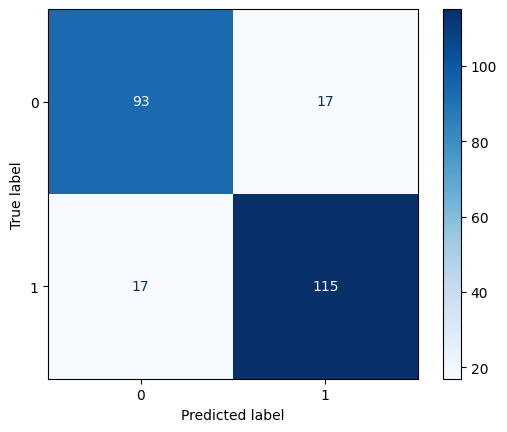

array([[ 93,  17],
       [ 17, 115]])

In [11]:
conf_matrix = confusion_matrix(y_train, y_train_predicted)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predicted, cmap=plt.cm.Blues)
plt.show()
conf_matrix

Recall score is very high (supposed to be), so is Precision, and they are very close. F1 is very high, obviously. But this is only for the training set. And the model is based on KNN, which is a subject for overfitting.
Now we shall do the real test, we'll use the test set. We are evaluating if the model can properly generalize.

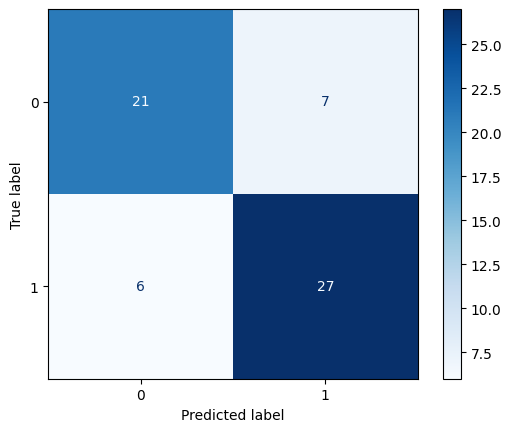

array([[21,  7],
       [ 6, 27]])

In [12]:
conf_matrix = confusion_matrix(y_test, y_test_predicted)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted, cmap=plt.cm.Blues)
plt.show()
conf_matrix

## Accuracy

In [13]:
accuracy_score(y_train, y_train_predicted), accuracy_score(y_test, y_test_predicted)

(0.859504132231405, 0.7868852459016393)

On the test the algorithm is not as good as on the train.

## Recall

In [14]:
recall_score(y_train, y_train_predicted), recall_score(y_test, y_test_predicted)

(0.8712121212121212, 0.8181818181818182)

## Precision

In [15]:
precision_score(y_train, y_train_predicted), precision_score(y_test, y_test_predicted)

(0.8712121212121212, 0.7941176470588235)

## F1-score

Recap of the situation.

In [16]:
f1_score(y_train, y_train_predicted), f1_score(y_test, y_test_predicted)

(0.8712121212121212, 0.8059701492537313)

(Overfitting case: comparison between train and test, train > test)
In the case of KNN we can analyze the impact of the k on the performance of the classifier. Here, we focus on recall as a function of hyperparameter k. 

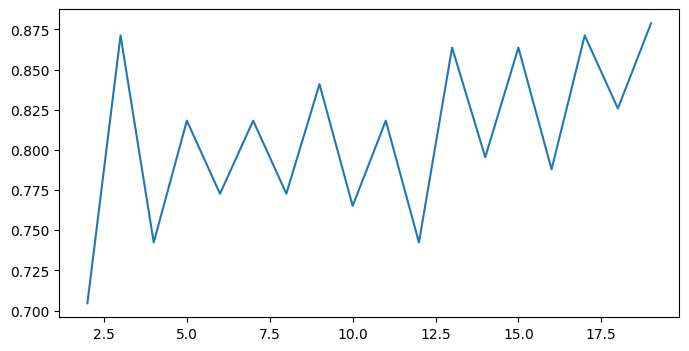

In [17]:
ks = range(2, 20)
recalls = []

for k in ks:
    cls = KNeighborsClassifier(n_neighbors=k)
    cls.fit(X_train, y_train)
    pred = cls.predict(X_train)
    recalls.append(recall_score(y_train, pred))
    
fig = plt.figure(figsize=(8, 4))
axes = fig.add_subplot()
axes.plot(ks, recalls)

Classical situation for KNN classifier, since it adapts to the shape of the data (by definition). KNN is not stable in terms of hyperparameter.

# Perceptron

SKLearn provides the class Perceptron in the module linear_models. The main parameter, i.e. the learning rate, is denoted by the parameter named eta0.

The weights of the model can be retrieved by the attribute coef_ and the bias is available by the attribute intercept_.

In [18]:
X, y = iris_data()

X = X[:, [0, 3]] # sepal length and petal length
X = X[0:100] # class 0 and class 1
y = y[0:100] # class 0 and class 1

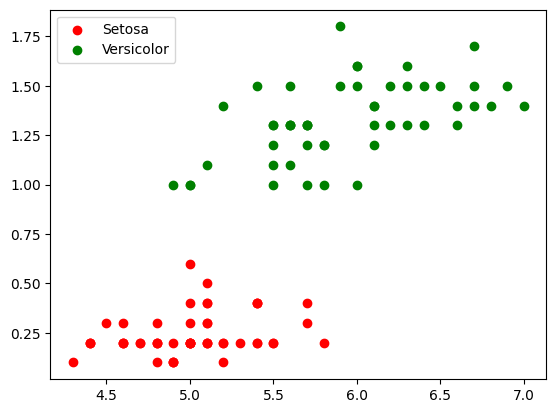

In [19]:
fig, ax = plt.subplots()
colors = ['red', 'green']
labels = ['Setosa', 'Versicolor']
for i in [0, 1]:
    ax.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=labels[i])
ax.legend()

In [20]:
clf_per = Perceptron()
clf_per.fit(X, y)

Perceptron()

<Axes: >

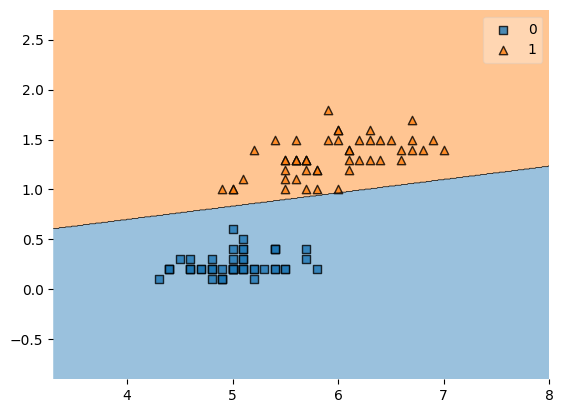

In [21]:
fig, ax = plt.subplots()
plot_decision_regions(X, y, clf=clf_per, ax=ax) # mlextend

# Adaline



In [22]:
class AdalineGD:
    """
    ADAptive LInear NEuron classifier.
    
    Parameters:
        eta: float - Learning rate in [0.0, 1.0]
        epochs: int - number of epochs/iterations
        random_state: int - Random number generator seed for random weight initialization
        
    Attributes:
        w_: 1d-array - weights after fitting
        b_: scalar - bias unit after fitting
        losses_: list - mean squared error (MSE) function values for each epoch
    
    """
    
    def __init__(self, eta=0.01, epochs=50, random_state=1):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        
    def fit(self, X, y):
        """
        Fit the training data
        :param X: (array-like), shape = [n_examples, n_features] -- training vectors, where n_examples is the number f examples and n_features is the number of features
        :param y: (array-like), shape = [n_examples] -- target values
        :return: self: object
        """
        rgen = np.random.default_rng(seed=self.random_state)
        
        # weights and bias initialization
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = rgen.normal(loc=0.0, scale=0.01)
        self.losses_ = []
        
        # the core algorithm
        for i in range(self.epochs):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * np.mean(errors)
            loss = (errors**2).sum()
            self.losses_.append(loss)
        return self
            
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X): # phi(x) = x
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Iteration: 30/30 | Cost 3.79 | Elapsed: 0:00:00 | ETA: 0:00:0000

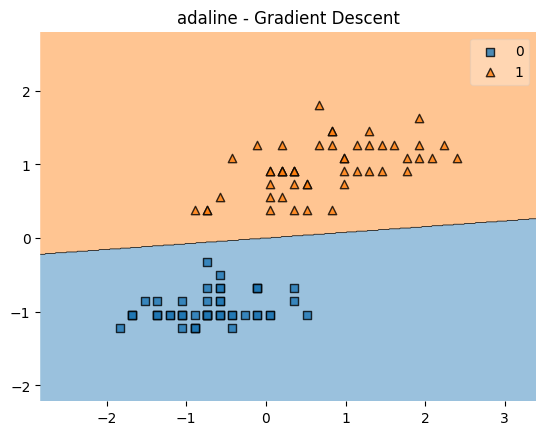

Text(0, 0.5, 'Cost')

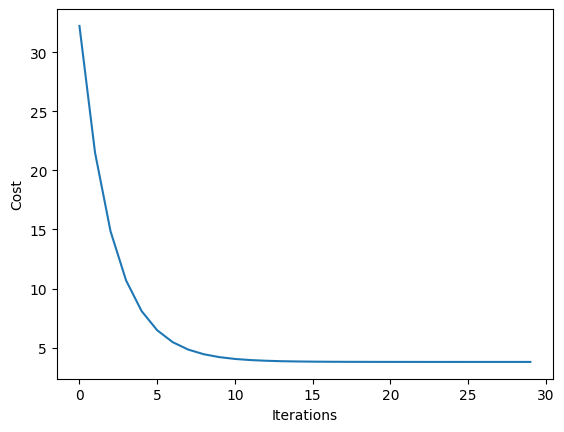

In [26]:
X_scaled = StandardScaler().fit_transform(X)

ada = Adaline(epochs=30, 
              eta=0.01,
              minibatches=1, # for Gradient Descent Learning
              random_seed=1,
              print_progress=3
)

ada.fit(X_scaled, y)
plot_decision_regions(X_scaled, y, clf=ada)
plt.title('adaline - Gradient Descent')
plt.show()

plt.plot(range(len(ada.cost_)), ada.cost_)
plt.xlabel('Iterations')
plt.ylabel("Cost")

## The role of the learning rate

Fixe the number of epochs - passes over the entire dataset, we plot the loss as a function of the epoch to verify if the algorithm converge/diverge and the rate of convergence.

In [24]:
ada = Adaline(epochs=30, 
              eta=0.01,
              minibatches=1, # for Gradient Descent Learning
              random_seed=1,
              print_progress=3
)

ada.fit(X, y)

Iteration: 30/30 | Cost 1504091984261082993597228610614283414133393420453841273882947459194670852380673343225856.00 | Elapsed: 0:00:00 | ETA: 0:00:00

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/var/folders/by/pqh4gvw52t5fm7pvbqnvcyy00000gn/T/ipykernel_33411/2463779196.py:4: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(range(1, 51), ada_cls.cost_, label=f'$\eta$={eta}', marker='x')
/Users/aleksandrak/Desktop/ML-course-Labs/.venv/lib/python3.12/site-packages/mlxtend/classifier/adaline.py:115: RuntimeWarning: overflow encountered in square
  return (errors**2).sum() / 2.0


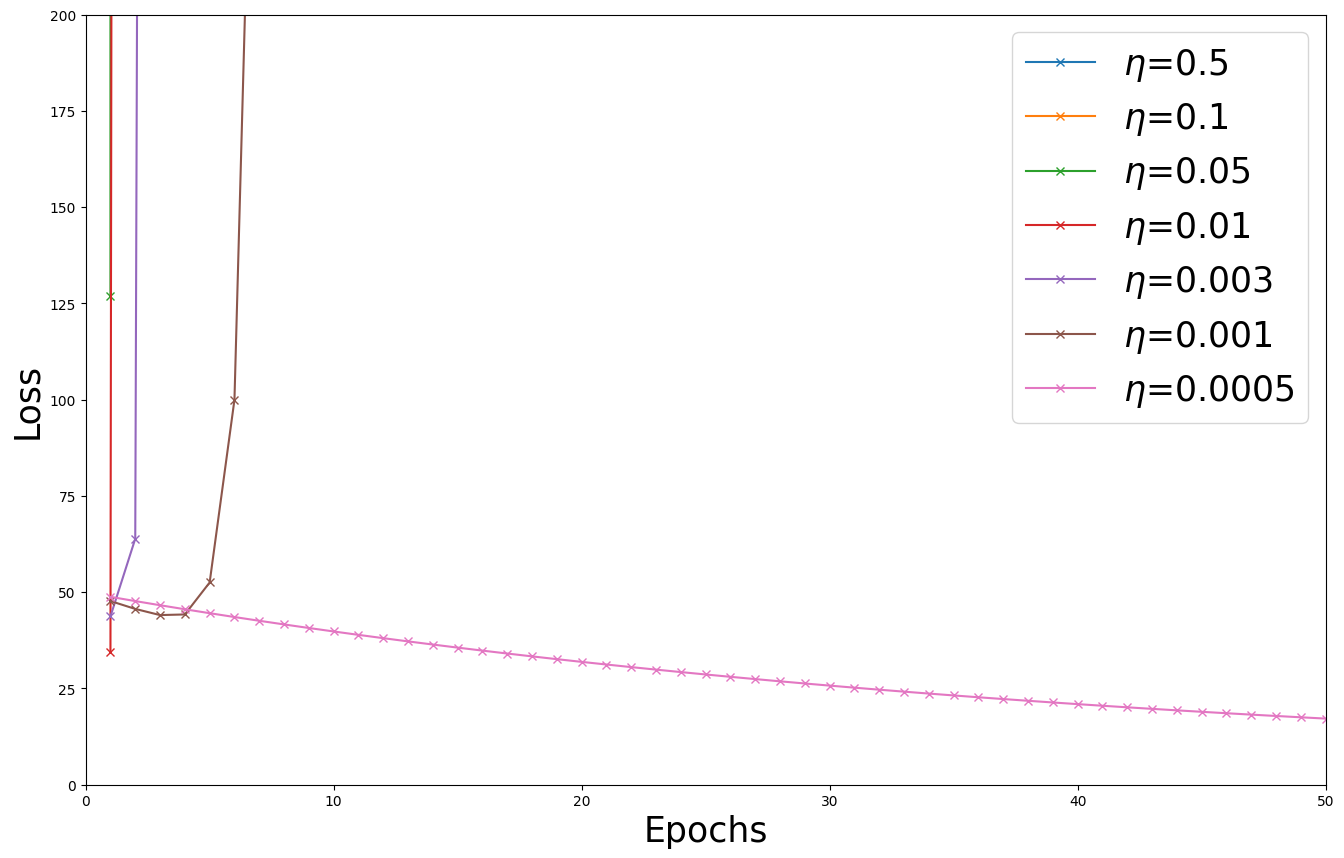

In [25]:
fig, ax = plt.subplots(figsize=(16, 10))
for eta in [0.5, 0.1, 0.05, 0.01, 0.003, 0.001, 0.0005]:
    ada_cls = Adaline(epochs=50, eta=eta, minibatches=1, random_seed=1).fit(X, y)
    ax.plot(range(1, 51), ada_cls.cost_, label=f'$\eta$={eta}', marker='x')
ax.set_ylim((0, 200))
ax.set_xlim((0, 50))
ax.set_xlabel('Epochs', size=25)
ax.set_ylabel('Loss', size=25)
ax.legend(fontsize=25)

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/var/folders/by/pqh4gvw52t5fm7pvbqnvcyy00000gn/T/ipykernel_33411/36386556.py:4: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(range(1, 51), ada_cls.cost_, label=f'$\eta$={eta}', marker='x')


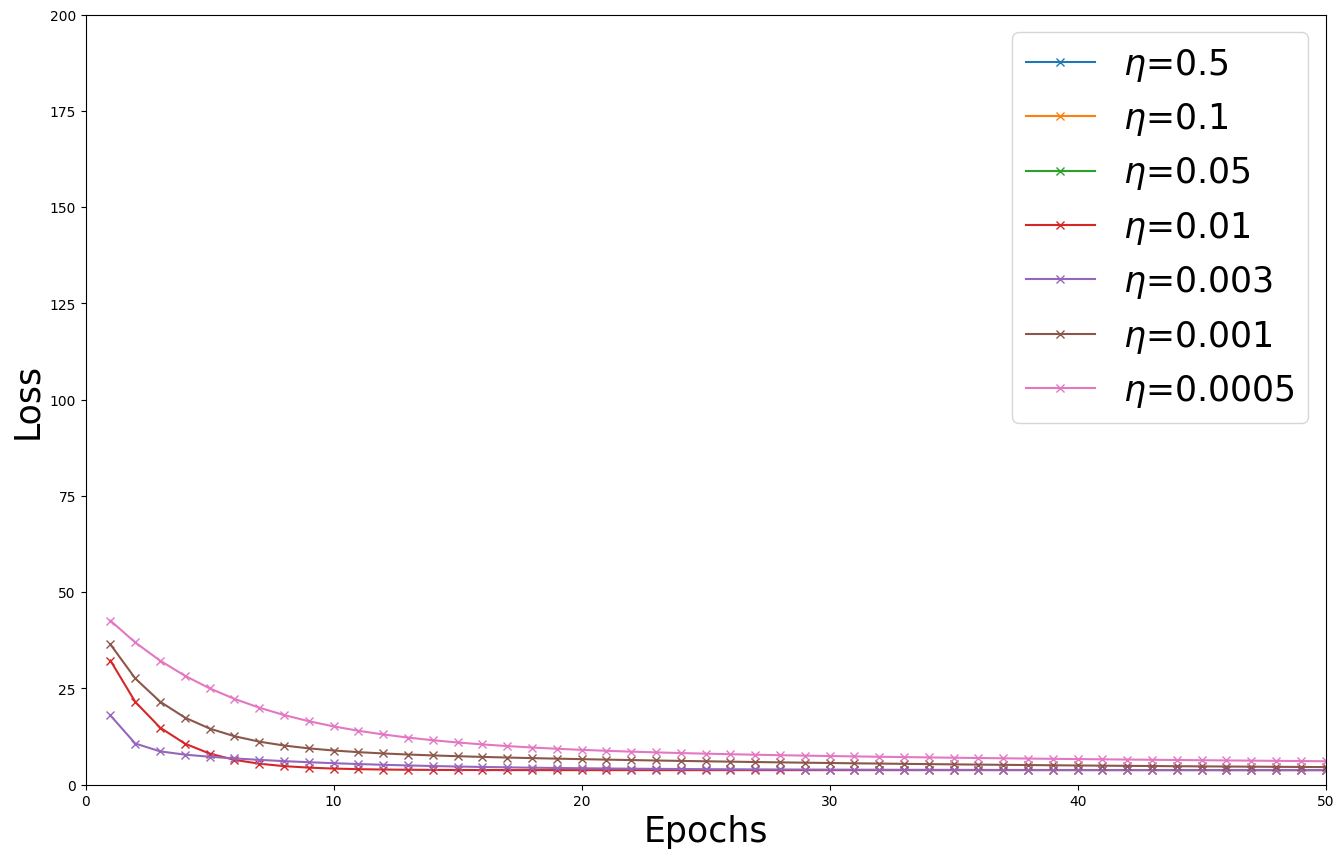

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))
for eta in [0.5, 0.1, 0.05, 0.01, 0.003, 0.001, 0.0005]:
    ada_cls = Adaline(epochs=50, eta=eta, minibatches=1, random_seed=1).fit(X_scaled, y)
    ax.plot(range(1, 51), ada_cls.cost_, label=f'$\eta$={eta}', marker='x')
ax.set_ylim((0, 200))
ax.set_xlim((0, 50))
ax.set_xlabel('Epochs', size=25)
ax.set_ylabel('Loss', size=25)
ax.legend(fontsize=25)